<h1>LSTM to the rescue<br>
Forward and backward propagation in LSTM


<h1>Predicting Bitcoin price using LSTM</h1>

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')


AttributeError: module 'tensorflow' has no attribute 'logging'

        Date  Symbol     Open     High      Low    Close  Volume From  \
0  5/26/2018  BTCUSD  7459.11  7640.46  7380.00  7520.00      2722.80   
1  5/25/2018  BTCUSD  7584.15  7661.85  7326.94  7459.11      8491.93   
2  5/24/2018  BTCUSD  7505.00  7734.99  7269.00  7584.15     11033.72   
3  5/23/2018  BTCUSD  7987.70  8030.00  7433.19  7505.00     14905.99   
4  5/22/2018  BTCUSD  8393.44  8400.00  7950.00  7987.70      6589.43   

      Volume To  
0  2.042265e+07  
1  6.342069e+07  
2  8.293137e+07  
3  1.148104e+08  
4  5.389753e+07  


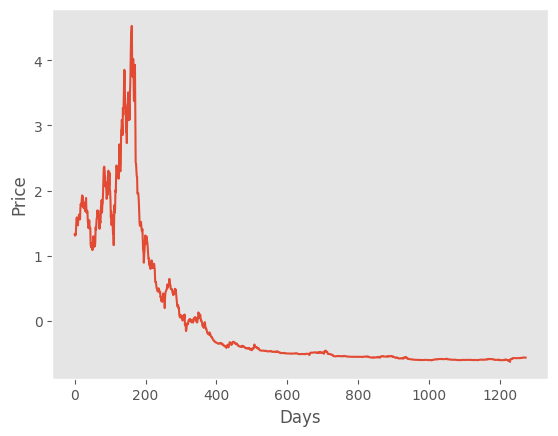

In [6]:
df=pd.read_csv("data/btc.csv")
print(df.head())

# We only take Closing price for calculation
data=df["Close"].values
# Next, we standardize the data and bring it to the same scale:
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))
 
# We then plot and observe the trend of how the Bitcoin price changes. Since
# we scaled the price, it is not a bigger number:
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Price') 
plt.grid()


In [7]:
# Define the get_data function
def get_data(data, window_size):
    X = []
    y = []
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i : i + window_size])
        y.append(data[i + window_size])
        i += 1
    assert len(X) == len(y)
    return X, y


X, y = get_data(data, window_size=7)

X_train = np.array(X[:1000])
y_train = np.array(y[:1000])
X_test = np.array(X[1000:])
y_test = np.array(y[1000:])

print(X_train.shape)

(1000, 7, 1)


<h5>Define Parameter

In [8]:
import tensorflow as tf

# Define network parameters
batch_size = 7
window_size = 7
hidden_layer = 256
learning_rate = 0.001

tf.compat.v1.disable_eager_execution()

# Define placeholders for input and output
input = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1])
target = tf.compat.v1.placeholder(tf.float32, [batch_size, 1])

# Define weights for LSTM gates

# Weights for input gate
U_i = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
W_i = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_i = tf.Variable(tf.zeros([hidden_layer]))

# Weights for forget gate
U_f = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
W_f = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_f = tf.Variable(tf.zeros([hidden_layer]))

# Weights for output gate
U_o = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
W_o = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_o = tf.Variable(tf.zeros([hidden_layer]))

# Weights for candidate state
U_g = tf.Variable(tf.random.truncated_normal([1, hidden_layer], stddev=0.05))
W_g = tf.Variable(tf.random.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
b_g = tf.Variable(tf.zeros([hidden_layer]))

# Output layer weights
V = tf.Variable(tf.random.truncated_normal([hidden_layer, 1], stddev=0.05))
b_v = tf.Variable(tf.zeros([1]))

<h5>Define LSTM Cell

In [9]:
def LSTM_cell(input, prev_hidden_state, prev_cell_state):
    # Input gate
    it = tf.sigmoid(tf.matmul(input, U_i) + tf.matmul(prev_hidden_state, W_i) + b_i)

    # Forget gate
    ft = tf.sigmoid(tf.matmul(input, U_f) + tf.matmul(prev_hidden_state, W_f) + b_f)

    # Output gate
    ot = tf.sigmoid(tf.matmul(input, U_o) + tf.matmul(prev_hidden_state, W_o) + b_o)

    # Candidate state
    gt = tf.tanh(tf.matmul(input, U_g) + tf.matmul(prev_hidden_state, W_g) + b_g)

    # Cell state update
    ct = (prev_cell_state * ft) + (it * gt)

    # Hidden state (output)
    ht = ot * tf.tanh(ct)

    return ct, ht

<h4> Forward Propagation

In [10]:
# Initialize the list for storing the output
y_hat = []


for i in range(batch_size):

    hidden_state = np.zeros([1, hidden_layer], dtype=np.float32)
    cell_state = np.zeros([1, hidden_layer], dtype=np.float32)

    # Perform forward propagation through LSTM for each time step
    for t in range(window_size):
        cell_state, hidden_state = LSTM_cell(
            tf.reshape(input[i][t], (-1, 1)), hidden_state, cell_state
        )

    y_hat.append(tf.matmul(hidden_state, V) + b_v)

<h4>Backward Propagation

In [11]:
# Initialize the list to store the losses
losses = []

mse = tf.keras.losses.MeanSquaredError()

for i in range(len(y_hat)):
    losses.append(mse(tf.reshape(target[i], (-1, 1)), y_hat[i]))

loss = tf.reduce_mean(losses)

gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, 4.0)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).apply_gradients(
    zip(clipped, tf.compat.v1.trainable_variables())
)

<h4> Training LSTM Model

In [12]:
# Start the TensorFlow session and initialize variables
session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())

epochs = 100

# Training loop
for i in range(epochs):
    train_predictions = []
    index = 0
    epoch_loss = []

    while (index + batch_size) <= len(X_train):

        X_batch = X_train[index : index + batch_size]
        y_batch = y_train[index : index + batch_size]

        predicted, loss_val, _ = session.run(
            [y_hat, loss, optimizer], feed_dict={input: X_batch, target: y_batch}
        )

        epoch_loss.append(loss_val)

        train_predictions.append(predicted)

        index += batch_size

    # Print the loss every 10 iterations
    if (i % 10) == 0:
        print("Epoch {}, Loss: {}".format(i, np.mean(epoch_loss)))

Epoch 0, Loss: 0.1823953539133072
Epoch 10, Loss: 0.040875375270843506
Epoch 20, Loss: 0.019999751821160316
Epoch 30, Loss: 0.013000105507671833
Epoch 40, Loss: 0.022245706990361214
Epoch 50, Loss: 0.008768349885940552
Epoch 60, Loss: 0.010577555745840073
Epoch 70, Loss: 0.009084261022508144


KeyboardInterrupt: 

<h4> Make Predictions

In [13]:
# Start making predictions on the test set
predicted_output = []
i = 0

# Loop through the test set in batches
while i + batch_size <= len(X_test):
    X_batch = X_test[i : i + batch_size]
    X_batch = X_batch.reshape((batch_size, window_size, 1))  # Reshape the input batch
    output = session.run(y_hat, feed_dict={input: X_batch})
    i += batch_size
    predicted_output.append(output)
print(predicted_output[0])


# Flatten the nested list of predicted values
predicted_values_test = []
for i in range(len(predicted_output)):
    for j in range(len(predicted_output[i])):
        predicted_values_test.append(predicted_output[i][j][0])
print(predicted_values_test[0])



predictions = []
for i in range(1280):
      if i >= 1000:
        predictions.append(predicted_values_test[i-1019][0])
      else:
        predictions.append(np.full(predicted_values_test[0][0].shape, None))
predictions = np.array(predictions)
print(predictions)


[array([[-0.60518396]], dtype=float32), array([[-0.602267]], dtype=float32), array([[-0.60131633]], dtype=float32), array([[-0.6004112]], dtype=float32), array([[-0.5999981]], dtype=float32), array([[-0.60173106]], dtype=float32), array([[-0.59772956]], dtype=float32)]
[-0.60518396]
[array(None, dtype=object) array(None, dtype=object)
 array(None, dtype=object) ... -0.5670302 -0.5666189 -0.56599665]


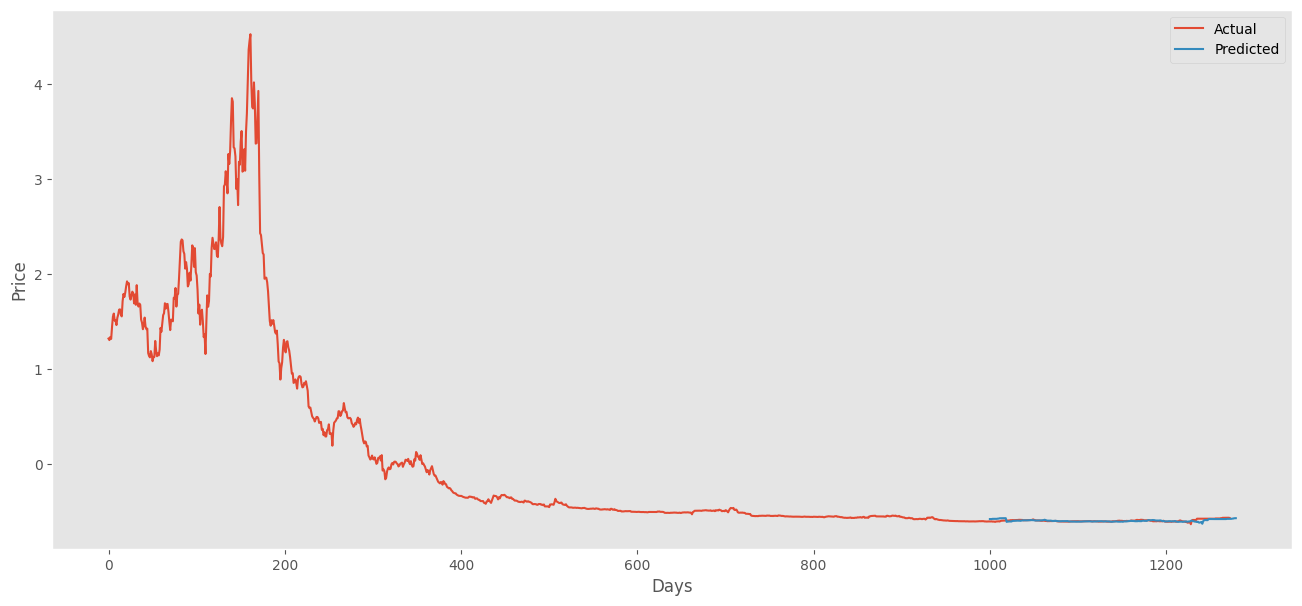

In [14]:
plt.figure(figsize=(16, 7))
plt.plot(data, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid()
plt.show()

<h1>GRU<br>
<h5>Define Weights

In [ ]:
vocab_size = 512
hidden_size = 64
input_size = 128
output_size = 10
init = tf.initializers.glorot_uniform()


# Weights for the update gate
Uz = tf.compat.v1.get_variable("Uz", [vocab_size, hidden_size], initializer=init)
Wz = tf.compat.v1.get_variable("Wz", [hidden_size, hidden_size], initializer=init)
bz = tf.compat.v1.get_variable("bz", [hidden_size], initializer=init)

# Weights for the reset gate
Ur = tf.compat.v1.get_variable("Ur", [vocab_size, hidden_size], initializer=init)
Wr = tf.compat.v1.get_variable("Wr", [hidden_size, hidden_size], initializer=init)
br = tf.compat.v1.get_variable("br", [hidden_size], initializer=init)

# Weights for the content state
Uc = tf.compat.v1.get_variable("Uc", [vocab_size, hidden_size], initializer=init)
Wc = tf.compat.v1.get_variable("Wc", [hidden_size, hidden_size], initializer=init)
bc = tf.compat.v1.get_variable("bc", [hidden_size], initializer=init)

# Weights for the output layer
V = tf.compat.v1.get_variable("V", [hidden_size, vocab_size], initializer=init)
by = tf.compat.v1.get_variable("by", [vocab_size], initializer=init)

<h5> Forward Propagation

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

x_t = tf.compat.v1.placeholder(tf.float32, [batch_size, vocab_size])
h_t = tf.compat.v1.get_variable("h_t", [batch_size, hidden_size], initializer=init)

zt = tf.sigmoid(tf.matmul(x_t, Uz) + tf.matmul(h_t, Wz) + bz)
rt = tf.sigmoid(tf.matmul(x_t, Ur) + tf.matmul(h_t, Wr) + br)
ct = tf.tanh(tf.matmul(x_t, Uc) + tf.matmul(tf.multiply(rt, h_t), Wc) + bc)
h_t = tf.multiply((1 - zt), ct) + tf.multiply(zt, h_t)
y_hat_t = tf.matmul(h_t, V) + by


<h1>Bidrectional RNN

In [ ]:
from tensorflow.compat.v1.nn import rnn_cell, static_bidirectional_rnn

num_hidden = 7

forward_hidden_layer = rnn_cell.LSTMCell(num_hidden, forget_bias=1.0)

backward_hidden_layer = rnn_cell.LSTMCell(num_hidden, forget_bias=1.0)

outputs, forward_states, backward_states = rnn_cell.static_bidirectional_rnn(forward_hidden_layer, backward_hidden_layer, input)
